# **Book Recommender System: Content Based Filtering**

# **Data Understanding**

In [1]:
pip install surprise

In [2]:
# Prepare all packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Unzip data
!unzip /content/buku.zip

Archive:  /content/buku.zip
replace Books.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
# Load Data
pengguna = pd.read_csv('/content/Users.csv')
nilai = pd.read_csv('/content/Ratings.csv')
buku = pd.read_csv('/content/Books.csv')

<ipython-input-4-cdc83f6b01f7>:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  buku = pd.read_csv('/content/Books.csv')


In [5]:
# Cek Shape
print(pengguna.shape)
print(nilai.shape)
print(buku.shape)

(278858, 3)
(1149780, 3)
(271360, 8)


### **Eksplorasi Dataset Buku**

In [6]:
# Cek info data buku
print(buku.shape)
buku.columns=['ISBN','Title','Author','Year_Of_Publication','Publisher','Image_URL_S','Image_URL_M','Image_URL_L']
buku.drop(['Image_URL_S','Image_URL_L'],axis=1,inplace=True)
buku.head()

(271360, 8)


,ISBN,Title,Author,Year_Of_Publication,Publisher,Image_URL_M
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.01.MZZZZZZZ.jpg
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.01.MZZZZZZZ.jpg
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.01.MZZZZZZZ.jpg
3,0374157065,Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.01.MZZZZZZZ.jpg
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.01.MZZZZZZZ.jpg


In [7]:
# Cek Missing Value
B = ((buku.isnull().sum()).sort_values()).to_dict()
for x in B:
  print(x, ":", B[x])

ISBN : 0
Title : 0
Year_Of_Publication : 0
Image_URL_M : 0
Author : 1
Publisher : 2


In [8]:
# Cek info data buku
buku.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Title                271360 non-null  object
 2   Author               271359 non-null  object
 3   Year_Of_Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image_URL_M          271360 non-null  object
dtypes: object(6)
memory usage: 12.4+ MB


In [9]:
# Cek data duplikat pada rows
duplicateRowsB = buku[buku.duplicated()]
duplicateRowsB.shape

(0, 6)

In [9]:
# Cek unique values dari ISBN dan title
print('unique ISBN: ', len(buku['ISBN'].unique()))
print('total rows: ', buku.shape[0])
print('unique title: ', len(buku['Title'].unique()))
print('total row: ', buku.shape[0])

unique ISBN:  271360
total rows:  271360
unique title:  242135
total row:  271360


Beberapa judul mengalami perulangan karena kuantitasnya tidak match dengan row

In [10]:
# Handle Missing Value dengan fillna
buku['Author'].fillna('Unknown', inplace=True)
buku['Publisher'].fillna('Unknown', inplace=True)
buku.isnull().sum()

ISBN                   0
Title                  0
Author                 0
Year_Of_Publication    0
Publisher              0
Image_URL_M            0
dtype: int64

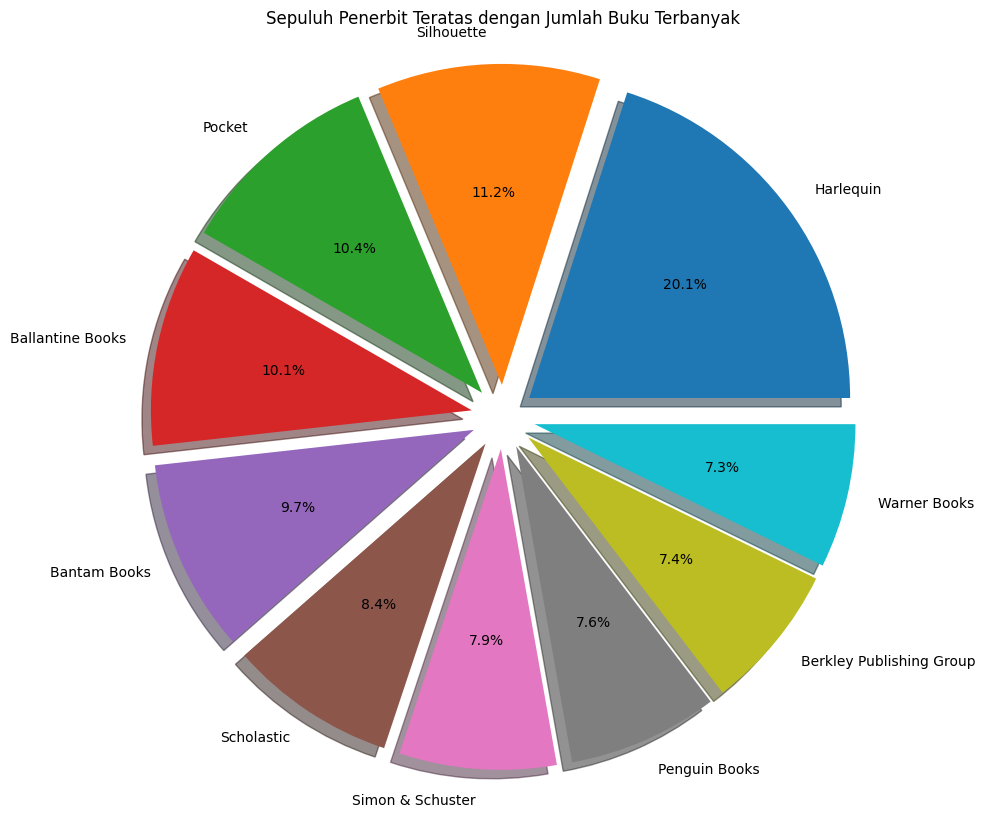

In [11]:
# Visualisasi Top 7 Publisher

my_lib = (buku['Publisher'].value_counts()).to_dict()
count = pd.DataFrame(list(my_lib.items()), columns=['c','count'])
A = count.sort_values(by=['count'], ascending=False)
A.head()

label = 'Harlequin', 'Silhouette', 'Pocket', 'Ballantine Books', 'Bantam Books','Scholastic','Simon & Schuster', 'Penguin Books', 'Berkley Publishing Group', 'Warner Books'
size = [count['count'].iloc[0],
        count['count'].iloc[1],
        count['count'].iloc[2],
        count['count'].iloc[3],
        count['count'].iloc[4],
        count['count'].iloc[5],
        count['count'].iloc[6],
        count['count'].iloc[7],
        count['count'].iloc[8],
        count['count'].iloc[9]]
explode  = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1 )
fig1, ax1 = plt.subplots(figsize=(10,10))
ax1.pie(
    size,
    explode = explode,
    labels = label,
    autopct = '%1.1f%%',
    shadow = True,
    startangle = 0
)

plt.title('Sepuluh Penerbit Teratas dengan Jumlah Buku Terbanyak')
ax1.axis('equal')
plt.show()

<ipython-input-12-70f8dd0f0d72>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')


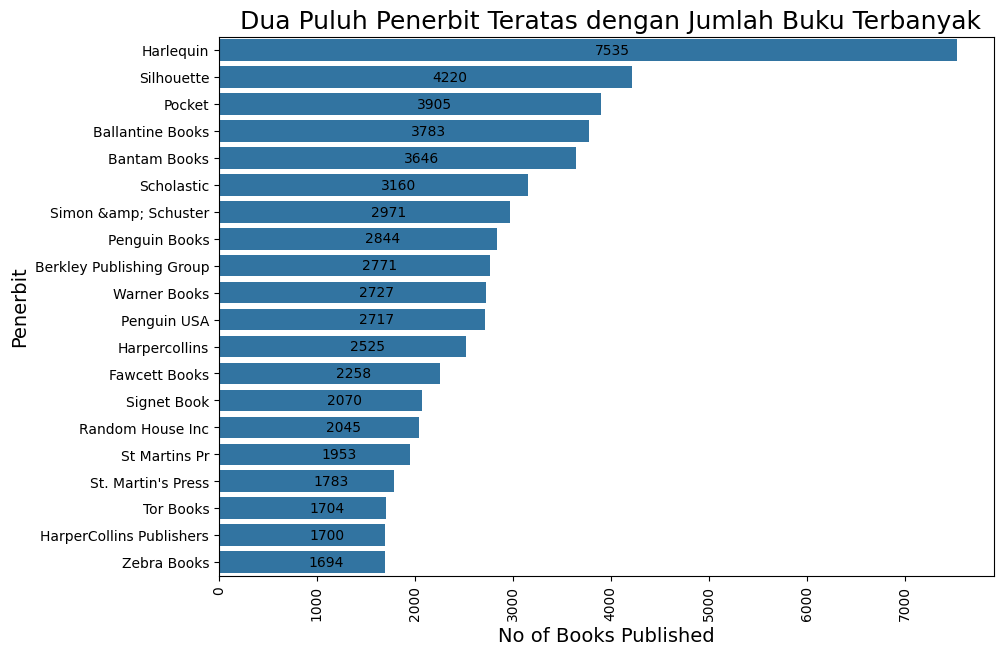

In [12]:
# Visualisasi Top 20 Publisher
top_20 = count.sort_values(by=['count'], ascending = False)
top_20 = top_20.head(20)
x =['Harlequin','Silhouette','Pocket','Ballantine Books','Bantam Books','Scholastic','Simon &amp; Schuster']
y = [7537,4220,3905,3783,3646,3160,2971]
fig=plt.figure(figsize=(10,7))
ax = sns.barplot(x = 'count',y = 'c' , data = top_20)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
plt.xlabel("No of Books Published", size=14)
plt.ylabel("Penerbit", size=14)
plt.title(" Dua Puluh Penerbit Teratas dengan Jumlah Buku Terbanyak", size=18)
for p in ax.patches:
    ax.annotate("%.0f" % p.get_width(), xy=(p.get_width()/2, p.get_y()+p.get_height()/2),
            xytext=(5, 0), textcoords='offset points', ha="left", va="center")
plt.show()

In [13]:
# Cek nilai unik dari Year_Of_Publication
np.set_printoptions(threshold=np.inf)
buku['Year_Of_Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

Terdapat nilai **0** dan **strings** pada kolom tahun

In [14]:
# Mencari posisi strings dan 0 pada Years_Of_Publications dan drop
index=buku.loc[buku['Year_Of_Publication']=='DK Publishing Inc'].index
buku.drop(index,inplace=True)

index=buku.loc[buku['Year_Of_Publication']=='Gallimard'].index
buku.drop(index,inplace=True)

buku['Year_Of_Publication'].replace({'0':buku['Year_Of_Publication'].value_counts().idxmax()},inplace=True)

buku['Year_Of_Publication'] = buku['Year_Of_Publication'].astype(str).astype(int)
buku['Year_Of_Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984,    0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, 2012, 2006, 1909, 2008, 1378,
       1919, 1922, 1897, 2024, 1376, 2037])

<ipython-input-15-fb0f25da033d>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y1['Year_Of_Publication'])


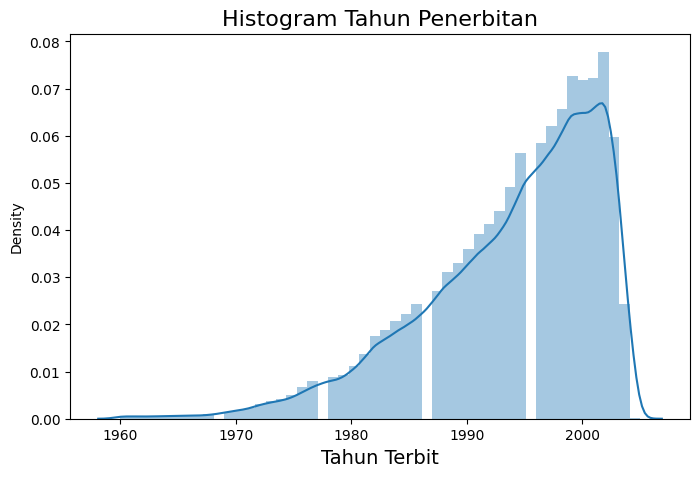

In [15]:
# Visualisasi Year of Publication
fig=plt.figure(figsize=(8,5))
y1 = buku[buku['Year_Of_Publication'] >= 1960]
y1 = y1[y1['Year_Of_Publication'] <= 2005]
sns.distplot(y1['Year_Of_Publication'])
plt.xlabel('Tahun Terbit',size=14)
plt.title('Histogram Tahun Penerbitan',size=16)
plt.show()


### **Eksplorasi Dataset Pengguna**

In [16]:
# Cek info dataset pengguna
print(pengguna.shape)

(278858, 3)


In [17]:
# Cek info dataset pengguna
pengguna.columns=['UserID', 'Location', 'Age']
pengguna.head()

,UserID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [18]:
# Cek info dataset pengguna
pengguna.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   UserID    278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [19]:
# Cek Missing Value
P = ((pengguna.isnull().sum()).sort_values()).to_dict()
for x in P:
  print(x, ":", P[x])

UserID : 0
Location : 0
Age : 110762


In [20]:
# Handle missing value dengan fillna
pengguna['Age'].fillna(pengguna['Age'].value_counts().idxmax(),inplace=True)

for x in pengguna['Age'][pengguna['Age']>95]:
  pengguna['Age'].replace({x:pengguna['Age'].value_counts().idxmax()},inplace=True)

for x in pengguna['Age'][pengguna['Age']==0]:
  pengguna['Age'].replace({x:pengguna['Age'].value_counts().idxmax()}, inplace=True)

pengguna['Age'] = pengguna['Age'].astype(int)
pengguna['Age'].unique()

array([24, 18, 17, 61, 26, 14, 25, 19, 46, 55, 32, 20, 34, 23, 51, 31, 21,
       44, 30, 57, 43, 37, 41, 54, 42, 50, 39, 53, 47, 36, 28, 35, 13, 58,
       49, 38, 45, 62, 63, 27, 33, 29, 66, 40, 15, 60, 79, 22, 16, 65, 59,
       48, 72, 56, 67,  1, 80, 52, 69, 71, 73, 78,  9, 64, 12, 74, 75,  3,
       76, 83, 68, 11, 77,  2, 70, 93,  8,  7,  4, 81, 10,  5,  6, 84, 82,
       90, 91, 94, 85, 86, 92, 87, 95, 89, 88])

In [21]:
# Cek Missing Value
P = ((pengguna.isnull().sum()).sort_values()).to_dict()
for x in P:
  print(x, ":", P[x])

UserID : 0
Location : 0
Age : 0


<ipython-input-22-efd559261b37>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(pengguna['Age'])


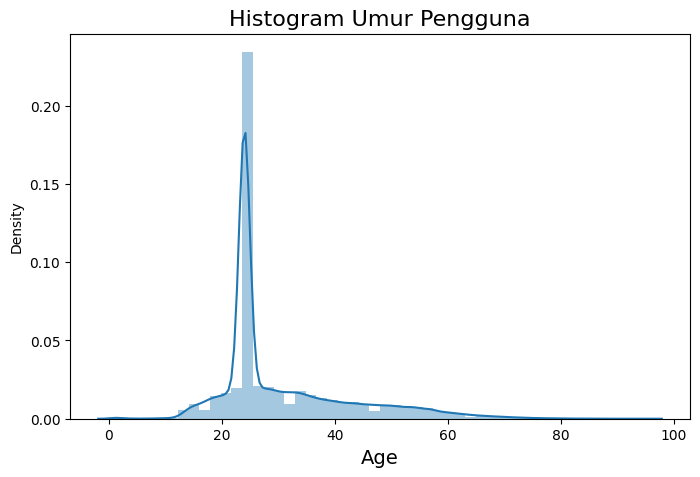

In [22]:
# Visualisasi Histogram Pada Umur Pengguna

figura = plt.figure(figsize=(8,5))
sns.distplot(pengguna['Age'])
plt.xlabel('Age', size=14)
plt.title('Histogram Umur Pengguna', size=16)
plt.show()

In [23]:
# Cek lokasi pengguna
pengguna['Location']

0                         nyc, new york, usa
1                  stockton, california, usa
2            moscow, yukon territory, russia
3                  porto, v.n.gaia, portugal
4         farnborough, hants, united kingdom
                         ...                
278853                 portland, oregon, usa
278854    tacoma, washington, united kingdom
278855             brampton, ontario, canada
278856             knoxville, tennessee, usa
278857                  dublin, n/a, ireland
Name: Location, Length: 278858, dtype: object

In [24]:
# Membuat dataframe pengguna baru dengan 9 kolom (7 kolom nan)
# Menerapkan fungsi lambda pada kolom Location,
# Merubah elemen menjadi string dengan str()
# Split string dengan comma, .split(",")
pengguna[['city', 'state', 'country', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']]=pengguna['Location'].apply(lambda x: pd.Series(str(x).split(",")))

#Restruktur dataframe dengan drop kolom Location dan Nan
pengguna.drop(['Location', 'nan'],axis=1, inplace=True)
pengguna

,UserID,Age,city,state,country
0,1,24,nyc,new york,usa
1,2,18,stockton,california,usa
2,3,24,moscow,yukon territory,russia
3,4,17,porto,v.n.gaia,portugal
4,5,24,farnborough,hants,united kingdom
...,...,...,...,...,...
278853,278854,24,portland,oregon,usa
278854,278855,50,tacoma,washington,united kingdom
278855,278856,24,brampton,ontario,canada
278856,278857,24,knoxville,tennessee,usa


Proses preprocessing data lokasi telah selesai dan data siap digunakan

Selanjutnya, preprocessing dan eksplorasi data rating

### **Rating**

In [26]:
# Cek informasi data rating
print(nilai.shape)

(1149780, 3)


In [27]:
# Cek informasi data rating
nilai.columns = ['UserID', 'ISBN', 'Rating']
nilai.head()

,UserID,ISBN,Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [28]:
# Cek nilai unik pada data rating
nilai['Rating'].unique()

array([ 0,  5,  3,  6,  8,  7, 10,  9,  4,  1,  2])

### **Merger Data Rating dan Pengguna Berdasarkan UserID**

In [29]:
# Filter data rating pada kolom UserID yg hanya tersedia di data pengguna pada kolom UserID
filter_UserID = nilai[nilai['UserID'].isin(pengguna['UserID'])]

# Filter data pada filter_UserID pada kolom ISBN harus tersedia pada data buku pada kolom ISBN juga
filter_ISBN = filter_UserID[filter_UserID['ISBN'].isin(buku['ISBN'])]

#Merger data pengguna dengan data filter_ISBN
df = pd.merge(pengguna, filter_ISBN, on='UserID')

# Tampilkan df
df

,UserID,Age,city,state,country,ISBN,Rating
0,2,18,stockton,california,usa,0195153448,0
1,8,24,timmins,ontario,canada,0002005018,5
2,8,24,timmins,ontario,canada,0060973129,0
3,8,24,timmins,ontario,canada,0374157065,0
4,8,24,timmins,ontario,canada,0393045218,0
...,...,...,...,...,...,...,...
1031127,278854,24,portland,oregon,usa,0425163393,7
1031128,278854,24,portland,oregon,usa,0515087122,0
1031129,278854,24,portland,oregon,usa,0553275739,6
1031130,278854,24,portland,oregon,usa,0553578596,0


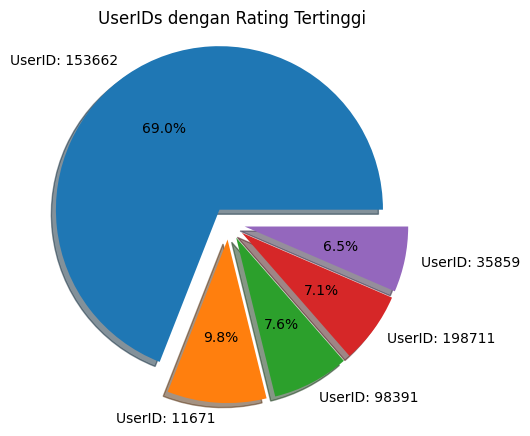

In [30]:
# Visualisasi UserID dengan rating tertinggi
# Visualisasi dengan Pie Chart
my_data = (filter_ISBN['Rating'].value_counts()).to_dict()
count = pd.DataFrame(list(my_data.items()), columns = ['c', 'count'])
b = count.sort_values(by=['count'], ascending = False)
b.head(5)

labels = 'UserID: 153662','UserID: 11671','UserID: 98391','UserID: 198711','UserID: 35859'
sizes = [count['count'].iloc[0],
         count['count'].iloc[1],
         count['count'].iloc[2],
         count['count'].iloc[3],
         count['count'].iloc[4]]
explode = (0.1, 0.1, 0.1, 0.1, 0.1)
fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(sizes,
        explode = explode,
        labels = labels,
        autopct = '%1.1f%%',
        shadow = True,
        startangle = 0)

plt.title('UserIDs dengan Rating Tertinggi')
ax1.axis('equal')
plt.show()

<ipython-input-31-a9a15134dd2d>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')


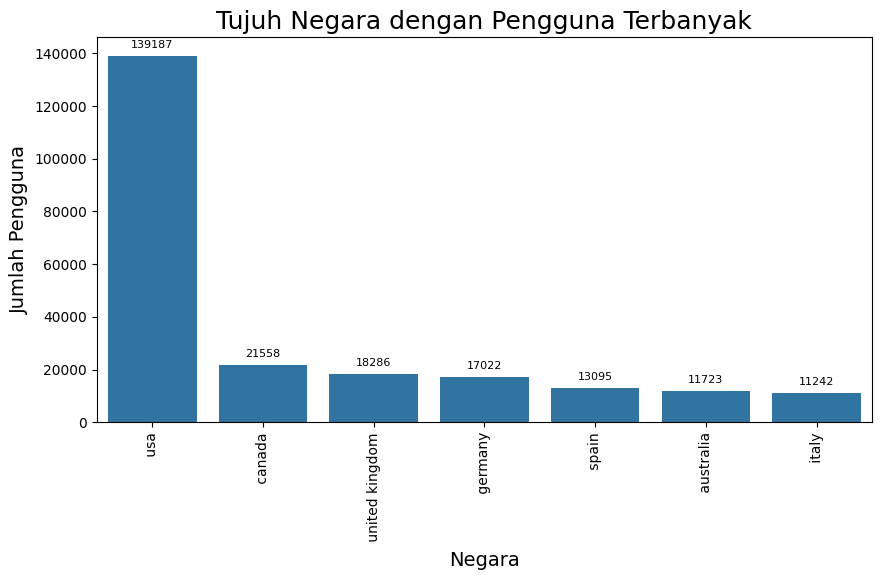

In [31]:
# Visualisasi negara dengan user terbanyak
my_data = (pengguna['country'].value_counts()).to_dict()
count = pd.DataFrame(list(my_data.items()), columns=['c', 'count'])
n = count.sort_values(by = ['count'], ascending = False)
n = n.head(7)
fig = plt.figure(figsize = (10,5))
ax = sns.barplot(y = 'count', x = 'c', data = n)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='center')
for bar in ax.patches:
    ax.annotate(format(bar.get_height(), '.0f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=8, xytext=(0,8),
                   textcoords='offset points')
plt.xlabel("Negara", size=14)
plt.ylabel("Jumlah Pengguna", size=14)
plt.title("Tujuh Negara dengan Pengguna Terbanyak", size=18)
plt.show()

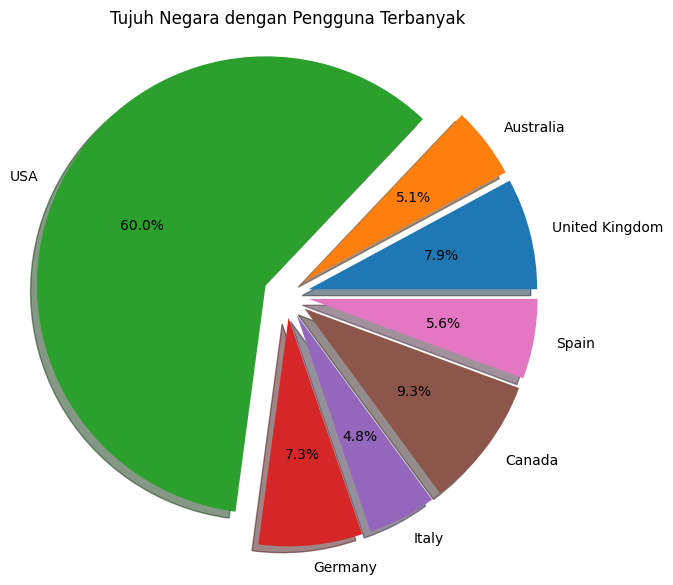

In [32]:
# Visualisasi Negara dengan Jumlah User Terbanyak
my_dict=(pengguna['country'].value_counts()).to_dict()
count= pd.DataFrame(list(my_dict.items()),columns = ['c','count'])
a = count.sort_values(by=['count'], ascending = False)
a.head(7)
labels = 'United Kingdom','Australia','USA','Germany','Italy','Canada','Spain'
sizes = [count['count'].iloc[2],count['count'].iloc[5],count['count'].iloc[0],count['count'].iloc[3],count['count'].iloc[6],
         count['count'].iloc[1],count['count'].iloc[4]]
explode = (0.1, 0.1, 0.1, 0.1,0.1, 0.1,0.1 )

fig1 , ax1 = plt.subplots(figsize=(7,7))

ax1.pie(sizes,
        explode = explode,
        labels = labels,
        autopct = '%1.1f%%',
        shadow = True,
        startangle = 0)
plt.title("Tujuh Negara dengan Pengguna Terbanyak")
ax1.axis ('equal')

plt.show()

In [33]:
pip install pycountry

In [34]:
# Ekstrak nama negara unik dari dataframe
coun=[]
for country in df["country"].unique():
    coun.append(country)

# Use the pycountry library to map country names to their corresponding 3-letter ISO codes,
# handling potential errors gracefully.
import pycountry
def do_fuzzy_search(country):
    result = pycountry.countries.search_fuzzy(country)
    return result[0].alpha_3

# Create a new DataFrame that contains the country names
# and their associated ISO codes (or 'unknown' for those not found).
iso_map=[]
c=[]
for i in coun:
    try:
        iso_map.append(do_fuzzy_search(i))
        c.append(i)
    except:
        iso_map.append('unknown')
        c.append(i)
        continue
df1=pd.DataFrame(iso_map,c,columns=['code'])
df1

SubdivisionHierarchy(code='GB-ENG', country_code='GB', name='England', parent_code=None, type='Country')
SubdivisionHierarchy(code='DE-BY', country_code='DE', name='Bayern', parent_code=None, type='Land')
SubdivisionHierarchy(code='US-TX', country_code='US', name='Texas', parent_code=None, type='State')
SubdivisionHierarchy(code='MX-MEX', country_code='MX', name='México', parent_code=None, type='State')
SubdivisionHierarchy(code='GT-GU', country_code='GT', name='Guatemala', parent_code=None, type='Department')
SubdivisionHierarchy(code='CA-BC', country_code='CA', name='British Columbia', parent_code=None, type='Province')
SubdivisionHierarchy(code='US-AZ', country_code='US', name='Arizona', parent_code=None, type='State')
SubdivisionHierarchy(code='BE-WLX', country_code='BE', name='Luxembourg', parent='WAL', parent_code='BE-WAL', type='Province')
SubdivisionHierarchy(code='LU-LU', country_code='LU', name='Luxembourg', parent_code=None, type='Canton')
SubdivisionHierarchy(code='US-NY', 

,code
usa,USA
canada,CAN
spain,ESP
,GBR
germany,DEU
...,...
andalucia,ESP
mozambique,MOZ
angola,AGO
"italy""",unknown


In [35]:
l=list(df1.index)
country_code=[]
for i in df['country']:
    if i in l:
        country_code.append(df1['code'].loc[df1.index==i][0])
df['Country_Code'] = np.array(country_code)

In [36]:
import pycountry
grouped = df.groupby(['Country_Code','country'])
avg=pd.DataFrame(grouped['Rating'].agg(np.mean))
avg.reset_index(inplace=True)
avg.columns=['Country Code','Country','Average Rating']
import plotly.express as px
fig = px.choropleth(avg,
                    locations=avg['Country Code'],
                    color=avg['Average Rating'],
                    hover_name=avg['Country'],
                    color_continuous_scale=px.colors.sequential.Plasma)
fig.show()

In [30]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import re
from PIL import Image
import requests
import random
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from nltk.corpus import stopwords

# **Sistem Rekomendasi Berdasarkan Popularitas Buku**

+ Sistem rekomendasi ini berdasarkan rating buku yang diberikan oleh pengguna
+ Sistem rekomendasi ini menunjukkan tren buku yang disukai pengguna saat ini

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
# Load data baru
buku_baru = pd.read_csv('/content/Books.csv')
user_baru = pd.read_csv('/content/Users.csv')
rating_baru = pd.read_csv('/content/Ratings.csv')

<ipython-input-2-a34048ae2783>:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  buku_baru = pd.read_csv('/content/Books.csv')


### **Data Preprocessing**

In [3]:
# Merger dataframe rating dengan buku berdasarkan ISBN
rating_buku = pd.merge(
    rating_baru,
    buku_baru,
    on='ISBN',
    how='left'
)
rating_buku

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
...,...,...,...,...,...,...,...,...,...,...
1149775,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...
1149776,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...
1149777,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...
1149778,276721,0590442449,10,Fourth Grade Rats,Jerry Spinelli,1996,Scholastic,http://images.amazon.com/images/P/0590442449.0...,http://images.amazon.com/images/P/0590442449.0...,http://images.amazon.com/images/P/0590442449.0...


In [4]:
# Grouping dataframe rating_buku berdasarkan ISBN
rating_buku.groupby('ISBN').sum()

<ipython-input-4-82848cadd244>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  rating_buku.groupby('ISBN').sum()


,User-ID,Book-Rating
ISBN,,
0330299891,271009,6
0375404120,356057,3
0586045007,89192,0
9022906116,100868,7
9032803328,89192,0
...,...,...
cn113107,107301,0
ooo7156103,266146,7
§423350229,85250,0


# **Sistem Rekomendasi: Content-Based Filtering**

In [5]:
# Cek missing value pada rating_buku
rating_buku.isnull().sum()

User-ID                     0
ISBN                        0
Book-Rating                 0
Book-Title             118644
Book-Author            118645
Year-Of-Publication    118644
Publisher              118646
Image-URL-S            118644
Image-URL-M            118644
Image-URL-L            118648
dtype: int64

In [6]:
# Drop missing value
rating_buku_bersih = rating_buku.dropna()
rating_buku_bersih

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002,Ballantine Books,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...,http://images.amazon.com/images/P/034545104X.0...
1,276726,0155061224,5,Rites of Passage,Judith Rae,2001,Heinle,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...,http://images.amazon.com/images/P/0155061224.0...
2,276727,0446520802,0,The Notebook,Nicholas Sparks,1996,Warner Books,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...,http://images.amazon.com/images/P/0446520802.0...
3,276729,052165615X,3,Help!: Level 1,Philip Prowse,1999,Cambridge University Press,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...,http://images.amazon.com/images/P/052165615X.0...
4,276729,0521795028,6,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...,http://images.amazon.com/images/P/0521795028.0...
...,...,...,...,...,...,...,...,...,...,...
1149774,276704,0876044011,0,Edgar Cayce on the Akashic Records: The Book o...,Kevin J. Todeschi,1998,A.R.E. Press (Association of Research &amp; Enlig,http://images.amazon.com/images/P/0876044011.0...,http://images.amazon.com/images/P/0876044011.0...,http://images.amazon.com/images/P/0876044011.0...
1149775,276704,1563526298,9,Get Clark Smart : The Ultimate Guide for the S...,Clark Howard,2000,Longstreet Press,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...,http://images.amazon.com/images/P/1563526298.0...
1149776,276706,0679447156,0,Eight Weeks to Optimum Health: A Proven Progra...,Andrew Weil,1997,Alfred A. Knopf,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...,http://images.amazon.com/images/P/0679447156.0...
1149777,276709,0515107662,10,The Sherbrooke Bride (Bride Trilogy (Paperback)),Catherine Coulter,1996,Jove Books,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...,http://images.amazon.com/images/P/0515107662.0...


In [7]:
# Cek missing value pada data bersih
rating_buku_bersih.isnull().sum()

User-ID                0
ISBN                   0
Book-Rating            0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
dtype: int64

In [8]:
# Standarisasi data
std_rating_buku = rating_buku_bersih.sort_values('ISBN', ascending=True)
std_rating_buku

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
703628,171118,0000913154,8,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...
866078,209516,0001010565,0,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...
357256,86123,0001010565,0,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...
103677,23902,0001046438,9,Liar,Stephen Fry,0,Harpercollins Uk,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...
807953,196149,0001046713,0,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...
...,...,...,...,...,...,...,...,...,...,...
1100731,264317,B000234N76,0,Falling Angels,Tracy Chevalier,2001,E P Dutton,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...
423108,100906,B000234NC6,0,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002,Knopf,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...
419279,100088,B00029DGGO,0,"Good Wife Strikes Back, The",Elizabeth Buchan,0,Viking Adult,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...
743545,179791,B0002JV9PY,0,The Blockade Runners,Jules Verne,0,Digireads.com,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...


In [9]:
# Cek panjang data unik pada ISBN
len(std_rating_buku['ISBN'].unique())

270145

In [10]:
# Cek panjang data unik pada Book-Title
len(std_rating_buku['Book-Title'].unique())

241066

In [11]:
data_fix = std_rating_buku.drop_duplicates('ISBN')
data_fix

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
703628,171118,0000913154,8,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...
866078,209516,0001010565,0,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...
103677,23902,0001046438,9,Liar,Stephen Fry,0,Harpercollins Uk,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...,http://images.amazon.com/images/P/0001046438.0...
807953,196149,0001046713,0,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...
103678,23902,000104687X,6,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993,HarperCollins Publishers,http://images.amazon.com/images/P/000104687X.0...,http://images.amazon.com/images/P/000104687X.0...,http://images.amazon.com/images/P/000104687X.0...
...,...,...,...,...,...,...,...,...,...,...
1100731,264317,B000234N76,0,Falling Angels,Tracy Chevalier,2001,E P Dutton,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...
423108,100906,B000234NC6,0,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002,Knopf,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...
419279,100088,B00029DGGO,0,"Good Wife Strikes Back, The",Elizabeth Buchan,0,Viking Adult,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...
743545,179791,B0002JV9PY,0,The Blockade Runners,Jules Verne,0,Digireads.com,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...


In [12]:
# Konversi data ISBN ke list
data_isbn = data_fix['ISBN'].tolist()

# Konversi data Book-Title ke list
data_book_title = data_fix['Book-Title'].tolist()

# Konversi data Book-Author ke list
data_book_author = data_fix['Book-Author'].tolist()

# Konversi data Year-Of-Publication ke list
data_Year = data_fix['Year-Of-Publication'].tolist()

# Konversi data publisher ke list
data_publisher = data_fix['Publisher'].tolist()

print(len(data_isbn))
print(len(data_book_title))
print(len(data_book_author))
print(len(data_Year))
print(len(data_publisher))

270145
270145
270145
270145
270145


In [13]:
# Dataframe baru
data_buku_fix = pd.DataFrame({
    'ISBN':data_isbn,
    'Book_Title':data_book_title,
    'Book_Author':data_book_author,
    'Year_Of_Publication':data_Year,
    'Publisher':data_publisher
})
data_buku_fix

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher
0,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster
1,0001010565,Mog's Christmas,Judith Kerr,1992,Collins
2,0001046438,Liar,Stephen Fry,0,Harpercollins Uk
3,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers
4,000104687X,"T.S. Eliot Reading \The Wasteland\"" and Other ...",T.S. Eliot,1993,HarperCollins Publishers
...,...,...,...,...,...
270140,B000234N76,Falling Angels,Tracy Chevalier,2001,E P Dutton
270141,B000234NC6,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002,Knopf
270142,B00029DGGO,"Good Wife Strikes Back, The",Elizabeth Buchan,0,Viking Adult
270143,B0002JV9PY,The Blockade Runners,Jules Verne,0,Digireads.com


In [14]:
# Hanya menggunakan 20.000 data karena terlalu besar
data_buku_fix = data_buku_fix[:20000]

### **TF-IDF Vectorizer**

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Inisiasi TfidVectorizer
tfidvect = TfidfVectorizer()

# Implementasi TfidVectorizer pada data_buku_fix di kolom Book_Author
tfidvect.fit(data_buku_fix['Book_Author'])

tfidvect.get_feature_names_out()


array(['1988', 'aaron', 'aarons', ..., 'zweifel', 'zwinger', 'â¼nter'],
      dtype=object)

In [16]:
# Transformasi ke matrix
tfidvect_matrix = tfidvect.fit_transform(data_buku_fix['Book_Author'])

# Cek shape
tfidvect_matrix.shape

(20000, 8746)

### **Cosine Similarity**

In [17]:
from sklearn.metrics.pairwise import cosine_similarity

# Hitung cosine similarity pada tfidvect_matrix
cosine_sim = cosine_similarity(tfidvect_matrix)
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [18]:
# Membuat dataframe dari cosine_sim
cosine_sim_df = pd.DataFrame(cosine_sim, index=data_buku_fix['Book_Title'], columns=data_buku_fix['Book_Title'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (20000, 20000)


Book_Title,The Circle of Simplicity: Return to the Good Life,The Heart of a Goof,The Log from the Sea of Cortez (Penguin Great Books of the 20th Century),Criminals,Hawaii (Frommer's City Guides)
Book_Title,,,,,
McAuslan in the Rough,0.0,0.0,0.0,0.0,0.0
How a Seed Grows (Let's-Read-and-Find-Out Science),0.0,0.0,0.0,0.0,0.0
The Shape of Things to Come,0.0,0.0,0.0,0.0,0.0
Art Since 1940 (2nd Edition),0.0,0.0,0.0,0.0,0.0
The Horse's Mouth,0.0,0.0,0.0,0.0,0.0
Good Intentions,0.0,0.0,0.0,0.0,0.0
Chemistry,0.0,0.0,0.0,0.0,0.0
Felicia's Journey,0.0,0.0,0.0,0.0,0.0
Judge Judy Sheindlin's Win or Lose by How You Choose,0.0,0.0,0.0,0.0,0.0


### **Mendapatkan Rekomendasi**

In [19]:
def rekomen_buku(data_book_title, similarity_data=cosine_sim_df, items=data_buku_fix[['Book_Title', 'Book_Author']], k=5):

     index = similarity_data.loc[:,data_book_title].to_numpy().argpartition(range(-1, -k, -1))

     # Retrieve data with the greatest similarity from the existing index
     closest = similarity_data.columns[index[-1:-(k+2):-1]]

     # Drop book_title so that the name of the book you are looking for does not appear in the recommendation list
     closest = closest.drop(data_book_title, errors='ignore')

     return pd.DataFrame(closest).merge(items).head(k)

In [20]:
book_title_tes = "Johnny Panic and the Bible of Dreams: Short Stories, Prose, and Diary Excerpts" # book title example

data_buku_fix[data_buku_fix.Book_Title.eq(book_title_tes)]

,ISBN,Book_Title,Book_Author,Year_Of_Publication,Publisher
6858,0060907479,Johnny Panic and the Bible of Dreams: Short St...,Sylvia Plath,1980,Harpercollins


In [21]:
# Tes Rekomendasi yg sudah dibuat
rekomen_buku(book_title_tes)

,Book_Title,Book_Author
0,"Letters home: Correspondence, 1950-1963",Sylvia Plath
1,Johnny Panic and the Bible of Dreams : Short S...,Sylvia Plath
2,Collected Poems Reissue,Sylvia Plath
3,The Bell Jar (Perennial Classics),Sylvia Plath
4,"Letters Home: Correspondence, 1950-1963",Sylvia Plath


### **Evaluasi**

In [22]:
# Tentukan threshold untuk kategorisasi similarity = 1 or 0
threshold = 0.5

# Buat ground truth data dengan threshold asumsi 1 or 0
ground_truth_data = np.where(cosine_sim >= threshold, 1, 0)

# Tampilkan nilai di ground truth data matrix
ground_truth_df = pd.DataFrame(ground_truth_data, index=data_buku_fix['Book_Title'],
                               columns=data_buku_fix['Book_Title']).sample(5, axis=1).sample(10, axis=0)

In [23]:
ground_truth_df

Book_Title,One Hundred Years of Solitude,"Sword and Shadow (Sword in Exile, Book 3)",Free to Trade: A Novel of Suspense,Workbook/Lab Manual t/a Pasajes: Lengua,Applications of Discrete Mathematics
Book_Title,,,,,
Tales of Ancient Egypt (Puffin Books),0,0,0,0,0
A House for Mr. Biswas,0,0,0,0,0
The lifeship,0,0,0,0,0
Hanover to Windsor,0,0,0,0,0
The King's Quest Companion,0,0,0,0,0
Descartes: Meditations On First Philosophy,0,0,0,0,0
World Turned Upside Down: Radical Ideas During the English Revolution (Penguin History),0,0,0,0,0
The Jungle Book (Puffin Classics),0,0,0,0,0
The Call of the Wild (Puffin Classics),0,0,0,0,0


In [24]:
from sklearn.metrics import precision_recall_fscore_support

# Mengambil sebagian kecil dari matriks kemiripan kosinus dan matriks ground truth
sample_size = 10000
cosine_sim_sample = cosine_sim[:sample_size, :sample_size]
ground_truth_sample = ground_truth_data[:sample_size, :sample_size]

# Mengonversi matriks kemiripan kosinus menjadi larik satu dimensi untuk perbandingan
cosine_sim_flat = cosine_sim_sample.flatten()

# Mengubah matriks kebenaran dasar menjadi larik satu dimensi
ground_truth_flat = ground_truth_sample.flatten()

# Menghitung metrics evaluasi
predictions = (cosine_sim_flat >= threshold).astype(int)
precision, recall, f1, _ = precision_recall_fscore_support(
     ground_truth_flat, predictions, average='binary', zero_division=1
)

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 1.0
Recall: 1.0
F1-score: 1.0


# **Sistem Rekomendasi: Collaborative Filtering**

In [25]:
# Hanya menggunakan 20000 data poin
rating_fix = rating_baru[:20000]
rating_fix

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
19995,3757,843222264X,7
19996,3757,8432222658,7
19997,3757,8432222666,7
19998,3757,8432222674,7


In [26]:
# Konversi User-ID ke list
USER_ID = rating_fix['User-ID'].unique().tolist()
print('List User-ID: ', USER_ID)

# Konversi User-ID encoding
user_encoding = {x: i for i, x in enumerate(USER_ID)}
print('Hasil Encoding User-ID: ', user_encoding)

# Proses encoding ke User-ID
encoding_user = {i: x for i, x in enumerate(USER_ID)}
print('Encoded number ke User-ID: ', encoding_user)

List User-ID:  [276725, 276726, 276727, 276729, 276733, 276736, 276737, 276744, 276745, 276746, 276747, 276748, 276751, 276754, 276755, 276760, 276762, 276765, 276768, 276772, 276774, 276780, 276786, 276788, 276796, 276798, 276800, 276803, 276804, 276806, 276808, 276811, 276812, 276813, 276814, 276817, 276820, 276822, 276827, 276828, 276830, 276832, 276833, 276835, 276837, 276838, 276840, 276842, 276847, 276848, 276850, 276852, 276853, 276854, 276856, 276857, 276859, 276861, 276862, 276863, 276866, 276869, 276870, 276872, 276873, 276875, 276878, 276879, 276884, 276887, 276888, 276889, 276890, 276896, 276904, 276905, 276911, 276912, 276915, 276916, 276925, 276927, 276928, 276929, 276934, 276936, 276939, 276943, 276946, 276949, 276950, 276953, 276954, 276957, 276959, 276963, 276964, 276965, 276975, 276981, 276984, 276986, 276988, 276989, 276990, 276992, 276994, 276997, 276998, 277002, 277007, 277009, 277010, 277012, 277018, 277019, 277022, 277023, 277028, 277031, 277032, 277035, 277036, 

In [27]:
# convert ISBNs ke list tanpa matching values
isbn_id = rating_fix['ISBN'].unique().tolist()

# Lakukan ISBN encoding
isbn_encoded = {x: i for i, x in enumerate(isbn_id)}

# Proses of encoding numbers to ISBN
encoded_isbn = {i: x for i, x in enumerate(isbn_id)}

In [28]:
# Nonaktifkan warning messages
pd.options.mode.chained_assignment = None # "warn" or "raise" to turn it back on

# Mapping User-ID ke user dataframe
rating_fix['user'] = rating_fix['User-ID'].map(user_encoding)

# Mapping ISBN ke book title dataframe
rating_fix['book_title'] = rating_fix['ISBN'].map(isbn_encoded)

In [29]:
# Dapatkan jumlah user
num_users = len(user_encoding)
print(num_users)

# Dapatkan jumlah judul buku
num_book_title = len(isbn_encoded)
print(num_book_title)

# convert the rating to a float value
rating_fix['Book-Rating'] = rating_fix['Book-Rating'].values.astype(np.float32)

# minimum rating value
min_rating = min(rating_fix['Book-Rating'])

# maximum rating value
max_rating = max(rating_fix['Book-Rating'])

print('Number of Users: {}, Number of Books: {}, Min Rating: {}, Max Rating: {}'.format(
     num_users, num_book_title, min_rating, max_rating
))

2180
17178
Number of Users: 2180, Number of Books: 17178, Min Rating: 0.0, Max Rating: 10.0


In [30]:
# Bagi data training dan validasi
rating_fix = rating_fix.sample(
    frac = 1,
    random_state = 42
)

rating_fix

,User-ID,ISBN,Book-Rating,user,book_title
10650,446,0061000280,10.0,1005,9861
2041,277478,0340565276,8.0,273,1978
8668,278418,1569751544,3.0,678,8223
1114,277195,0394726413,0.0,173,1098
13902,1928,0373196903,0.0,1511,12430
...,...,...,...,...,...
11284,651,1888451084,7.0,1071,10381
11964,929,0345331605,7.0,1163,10917
5390,278418,0373121962,0.0,678,5066
860,277087,8472230082,5.0,139,850


In [31]:
# buat variabel x to match user data dan book title menjadi satu nilai
x = rating_fix[['user', 'book_title']].values

# create a y variable to create a rating of the results
y = rating_fix['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# divide into 90% train data and 10% validation data

train_indices = int(0.9 * rating_fix.shape[0])
x_train, x_val, y_train, y_val = (
     x[:train_indices],
     x[train_indices:],
     y[:train_indices],
     y[train_indices:]
)

print(x, y)

[[ 1005  9861]
 [  273  1978]
 [  678  8223]
 ...
 [  678  5066]
 [  139   850]
 [ 1706 13939]] [1.  0.8 0.3 ... 0.  0.5 0. ]


In [32]:
# Proses Training

class RecommenderNet(tf.keras.Model):

     # function initialization
     def __init__(self, num_users, num_book_title, embedding_size, dropout_rate=0.2, **kwargs):
         super(RecommenderNet, self).__init__(**kwargs)
         self.num_users = num_users
         self.num_book_title = num_book_title
         self. embedding_size = embedding_size
         self.dropout_rate = dropout_rate

         self.user_embedding = layers.Embedding( # user embedding layer
             num_users,
             embedding_size,
             embeddings_initializer = 'he_normal',
             embeddings_regularizer =keras.regularizers.l2(1e-6)
         )
         self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias

         self.book_title_embedding = layers.Embedding( # book_title embedding layer
             num_book_title,
             embedding_size,
             embeddings_initializer = 'he_normal',
             embeddings_regularizer =keras.regularizers.l2(1e-6)
         )
         self.book_title_bias = layers.Embedding(num_book_title, 1) # layer embedding book_title

         self.dropout = layers.Dropout(rate=dropout_rate)

     def call(self, inputs):
         user_vector = self.user_embedding(inputs[:, 0]) # call embedding layer 1
         user_vector = self.dropout(user_vector)
         user_bias = self.user_bias(inputs[:, 0]) # call embedding layer 2

         book_title_vector = self.book_title_embedding(inputs[:, 1]) # call embedding layer 3
         book_title_vector = self.dropout(book_title_vector)
         book_title_bias = self.book_title_bias(inputs[:, 1]) # call embedding layer 4

         dot_user_book_title = tf.tensordot(user_vector, book_title_vector, 2) # dot product multiplication

         x = dot_user_book_title + user_bias + book_title_bias

         return tf.nn.sigmoid(x) # activate sigmoid

In [33]:
model = RecommenderNet(num_users, num_book_title, 50) # initialize model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=1e-4),
    metrics = [tf.keras.metrics.RootMeanSquaredError()]
)

In [34]:
# start the training process

history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 16,
    epochs = 50,
    validation_data = (x_val, y_val)
)

Epoch 1/50
1125/1125 [==============================] - 14s 12ms/step - loss: 0.6923 - root_mean_squared_error: 0.4410 - val_loss: 0.6843 - val_root_mean_squared_error: 0.4339
Epoch 2/50
1125/1125 [==============================] - 13s 11ms/step - loss: 0.6713 - root_mean_squared_error: 0.4290 - val_loss: 0.6705 - val_root_mean_squared_error: 0.4259
Epoch 3/50
1125/1125 [==============================] - 13s 11ms/step - loss: 0.6445 - root_mean_squared_error: 0.4132 - val_loss: 0.6578 - val_root_mean_squared_error: 0.4184
Epoch 4/50
1125/1125 [==============================] - 13s 11ms/step - loss: 0.6115 - root_mean_squared_error: 0.3934 - val_loss: 0.6462 - val_root_mean_squared_error: 0.4115
Epoch 5/50
1125/1125 [==============================] - 13s 11ms/step - loss: 0.5795 - root_mean_squared_error: 0.3745 - val_loss: 0.6358 - val_root_mean_squared_error: 0.4054
Epoch 6/50
1125/1125 [==============================] - 13s 12ms/step - loss: 0.5586 - root_mean_squared_error: 0.3632 -

### **Mendapatkan Rekomendasi**

In [35]:
book_df = data_buku_fix

# Ambil sampel pengguna
user_id = rating_fix['User-ID'].sample(2).iloc[0]
book_readed_by_user = rating_fix[rating_fix['User-ID'] == user_id]

# buat variabel book_not_readed
book_not_readed = book_df[~book_df['ISBN'].isin(book_readed_by_user['ISBN'].values)]['ISBN']
book_not_readed = list(
    set(book_not_readed)
    .intersection(set(isbn_encoded.keys()))
)

book_not_readed = [[isbn_encoded.get(x)] for x in book_not_readed]
user_encoder = user_encoding.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(book_not_readed), book_not_readed)
)

In [36]:
ratings_model = model.predict(user_book_array).flatten()

top_ratings_indices = ratings_model.argsort()[-10:][::-1]

recommended_book_ids = [
    encoded_isbn.get(book_not_readed[x][0]) for x in top_ratings_indices
]

top_book_user = (
    book_readed_by_user.sort_values(
        by='Book-Rating',
        ascending=False
    )
    .head(10)['ISBN'].values
)

book_df_rows = book_df[book_df['ISBN'].isin(top_book_user)]

# Displays book recommendations in DataFrame form
book_df_rows_data = []
for row in book_df_rows.itertuples():
    book_df_rows_data.append([row.Book_Title, row.Book_Author])

recommended_book = book_df[book_df['ISBN'].isin(recommended_book_ids)]

recommended_book_data = []
for row in recommended_book.itertuples():
    recommended_book_data.append([row.Book_Title, row.Book_Author])

# Create a DataFrame for output
output_columns = ['Book Title', 'Book Author']
df_book_readed_by_user = pd.DataFrame(book_df_rows_data, columns=output_columns)
df_recommended_books = pd.DataFrame(recommended_book_data, columns=output_columns)

# Displays recommendation results in DataFrame form
print("Showing recommendation for users: {}".format(user_id))
print("---" * 9)
print("Book with high ratings from user")
print("..." * 8)
print(df_book_readed_by_user)
print("..." * 8)
print("Top 10 books recommendation")
print("..." * 8)
df_recommended_books

34/34 [==============================] - 1s 1ms/step
Showing recommendation for users: 280
---------------------------
Book with high ratings from user
........................
Empty DataFrame
Columns: [Book Title, Book Author]
Index: []
........................
Top 10 books recommendation
........................


,Book Title,Book Author
0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1,The Lives of Christopher Chant,Diana Wynne Jones
2,Little Altars Everywhere,Rebecca Wells
3,The Holiday Present,Johanna Lindsey
4,The Perfect Storm : A True Story of Men Agains...,Sebastian Junger
5,Kane &amp; Abel,Jeffrey Archer
6,Memoirs of a Geisha Uk,Arthur Golden
7,Junky,William Burroughs
8,Are You Experienced?,William Sutcliffe
9,Life on the Mississippi (Penguin Classics),Mark Twain


### **Evaluasi**

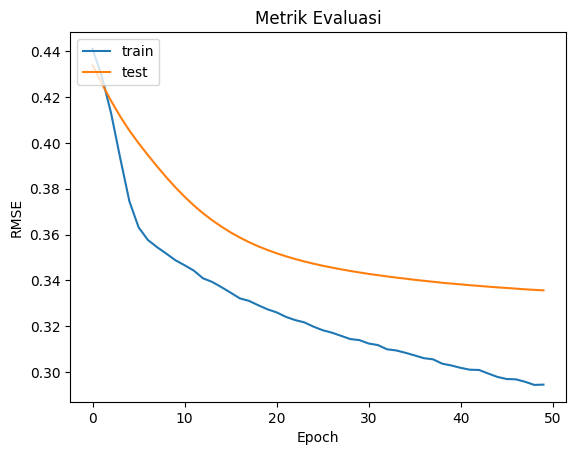

In [37]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('Metrik Evaluasi')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()